## Importing libraries

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix,f1_score,precision_score,recall_score
wordnet_lemmatizer = WordNetLemmatizer()

###  Read the dataset

In [47]:
df = pd.read_csv("D:\Projects\College project\Machine learning model\Tweets.csv")

In [97]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
5660,568829494556897280,negative,1.0000,Late Flight,0.3474,Southwest,NaN,bluefig,NaN,0,"@SouthwestAir so, when your plane doesn't work...",NaN,2015-02-20 09:48:14 -0800,"camas, wa",Alaska
4547,570040162840907776,neutral,0.6696,NaN,0.0000,Southwest,NaN,Aubrey__Cyr,NaN,0,@SouthwestAir how much is ur wifi fam,NaN,2015-02-23 17:59:00 -0800,CT,NaN
8237,568569662717313024,positive,1.0000,NaN,NaN,Delta,NaN,thaniapeck,NaN,0,@JetBlue thanks so much!! ❤️✨ very relaxing fl...,NaN,2015-02-19 16:35:45 -0800,NaN,Pacific Time (US & Canada)
13933,569689370988408832,negative,1.0000,Customer Service Issue,1.0000,American,NaN,c_cgottlieb,NaN,0,@AmericanAir 1 ticket agent servicing at least...,NaN,2015-02-22 18:45:05 -0800,"Washington, DC",Atlantic Time (Canada)
7648,569439829328408576,positive,1.0000,NaN,NaN,Delta,NaN,logantracey,NaN,0,@JetBlue They just came out. Thanks for the fo...,NaN,2015-02-22 02:13:29 -0800,new york city,Eastern Time (US & Canada)


In [49]:
df.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


## Data Preprocessing

In [59]:
def normalizer(tweet):
    # remove URLs
    only_letters = re.sub("http\S+", "", tweet)
    # replace @username with user
    only_letters = re.sub("@\w+", "user", only_letters)
    # remove all symbols except hashtags
    only_letters = re.sub("[^\w\s#]", "", only_letters)
    # convert to lowercase
    only_letters = only_letters.lower()
    only_letters = only_letters.split()
    
    # tokenize the tweet
#     tokens = nltk.word_tokenize(only_letters)
    # remove stopwords
    filtered_result = [word for word in only_letters if word not in stopwords.words('english')]
    # lemmatize words using WordNetLemmatizer
    lemmas = [WordNetLemmatizer().lemmatize(t) for t in filtered_result]
    # join the lemmas back into a string
    lemmas = ' '.join(lemmas)
    return lemmas


In [60]:
normalizer('Movie is okay')

'movie okay'

In [61]:
df = shuffle(df)
y = df['airline_sentiment']
x = df.text.apply(normalizer)

## Sentiment distribution

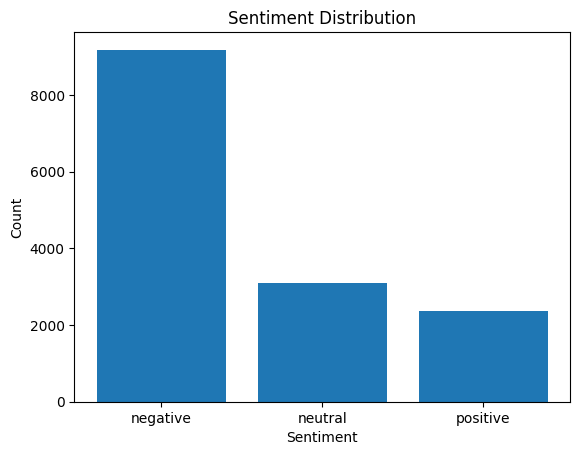

In [62]:
%matplotlib inline

sentiment_counts = df['airline_sentiment'].value_counts()
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

## Word cloud of the frequently used words

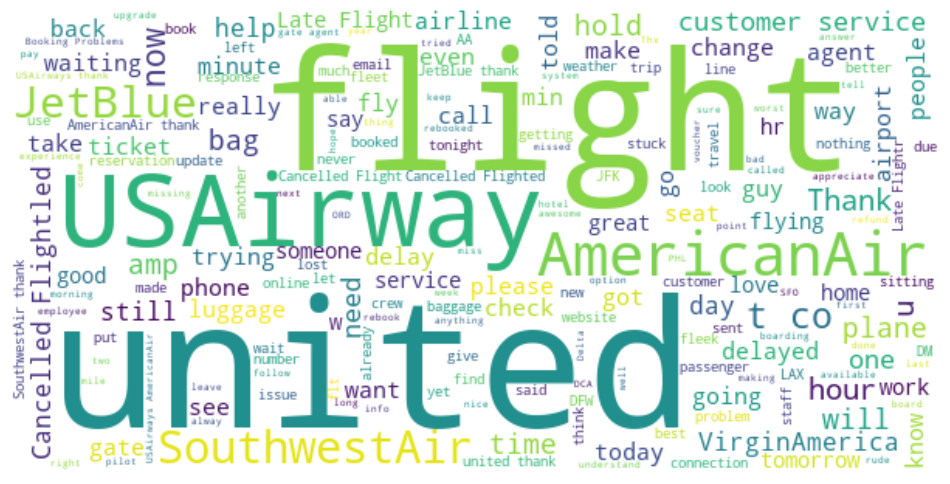

In [63]:
%matplotlib inline
# concatenate all the tweets into a single string
all_tweets = " ".join(tweet for tweet in df['text'])

# generate a word cloud image
wordcloud = WordCloud(width=600, height=300, background_color="white").generate(all_tweets)

# display the image
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Converts a collection of text documents to a matrix of token counts.

In [64]:
vectorizer = CountVectorizer()
x_vectorized = vectorizer.fit_transform(x)

In [65]:
x_vectorized

<14640x13661 sparse matrix of type '<class 'numpy.int64'>'
	with 143399 stored elements in Compressed Sparse Row format>

In [67]:
x_vectorized.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

### Train the data

In [68]:
train_x,val_x,train_y,val_y = train_test_split(x_vectorized,y, test_size=0.3, random_state=42)

In [69]:
print('Number of samples in training sets: ', train_x.shape[0])
print('Number of samples in test sets: ', val_x.shape[0])


Number of samples in training sets:  10248
Number of samples in test sets:  4392


## Machine Learning model training

In [70]:
regressor = LogisticRegression(multi_class='multinomial', solver='newton-cg')
model = regressor.fit(train_x, train_y)

In [71]:
params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
gs_clf = GridSearchCV(model, params, n_jobs=1, cv=5)
gs_clf = gs_clf.fit(train_x, train_y)
model = gs_clf.best_estimator_
     

In [72]:
y_pred = model.predict(val_x)

_f1 = f1_score(val_y, y_pred, average='micro')
_confusion = confusion_matrix(val_y, y_pred)
__precision = precision_score(val_y, y_pred, average='micro')
_recall = recall_score(val_y, y_pred, average='micro')
_statistics = {'f1_score': _f1,
               'confusion_matrix': _confusion,
               'precision': __precision,
               'recall': _recall
              }

In [73]:
print(_statistics)

{'f1_score': 0.7868852459016392, 'confusion_matrix': array([[2455,  242,   87],
       [ 293,  529,   80],
       [ 127,  107,  472]], dtype=int64), 'precision': 0.7868852459016393, 'recall': 0.7868852459016393}


## Plot the confusion matrix

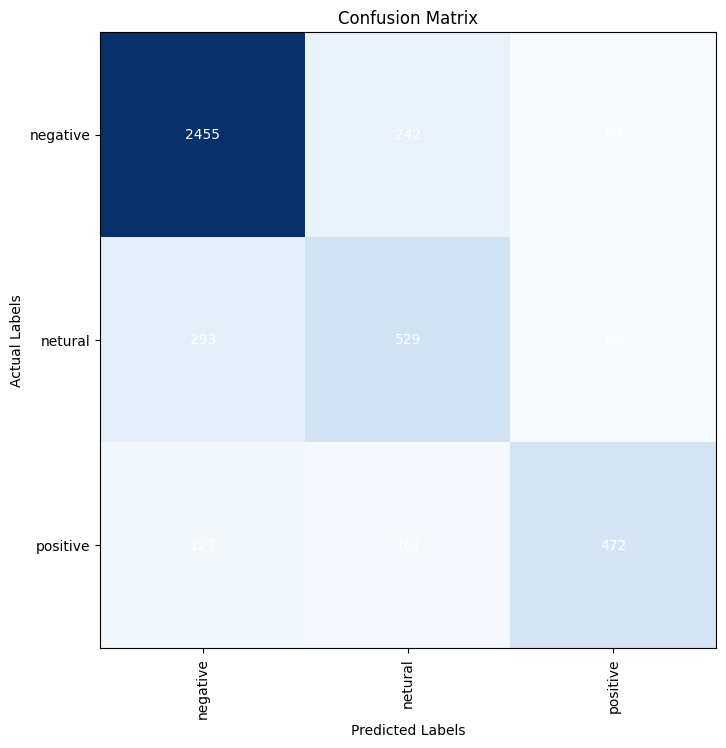

In [104]:
%matplotlib inline

classes = ['negative', 'netural', 'positive']
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(_confusion, cmap='Blues')
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('Actual Labels')
ax.xaxis.set(ticks=range(len(classes)))
ax.yaxis.set(ticks=range(len(classes)))
ax.set_xticklabels(classes, rotation=90)
ax.set_yticklabels(classes)
for i in range(len(classes)):
    for j in range(len(classes)):
        ax.text(j, i, _confusion[i, j], ha='center', va='center', color='white')
plt.show()

#### Test some of the outputs

In [74]:
test_feature = vectorizer.transform(['Meat Week Day 3: I am okay'])
model.predict(test_feature)

array(['neutral'], dtype=object)

In [78]:
test_feature = vectorizer.transform(['Product  is  good'])
model.predict(test_feature)

array(['positive'], dtype=object)

In [96]:
test_feature = vectorizer.transform(['@JetBlue thanks so much!! ❤️✨ very relaxing flight!'])
model.predict(test_feature)

array(['positive'], dtype=object)

### Export the model

In [79]:
import pickle


In [81]:
pickl = {'vectorizer': vectorizer,
         'model': model
         }
pickle.dump(pickl, open('models'+".p", "wb"))